In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
DATASET_PATH = "../datasets/dblp.txt"

In [32]:
df = pd.read_csv(DATASET_PATH, sep="\t", names=["source", "target"])

In [33]:
df.head()

,source,target
0,0,1
1,0,2
2,0,4519
3,0,23073
4,0,33043


In [48]:
graph = nx.from_pandas_edgelist(df.head(100))

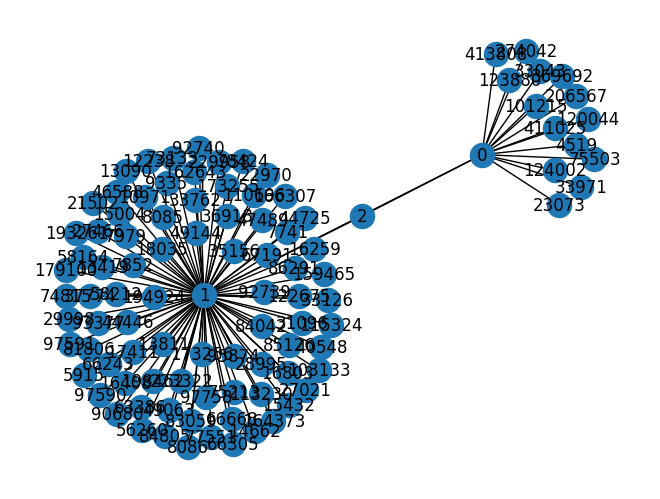

In [54]:
nx.draw(graph, font_weight='light', with_labels=True)

In [ ]:
for node in graph.nodes():
    for delta in range(6, 17):
        delta = delta / 10
